Загрузка данных...

Training Data Analysis:
Shape: (8523, 12)

Feature Statistics:
       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          310

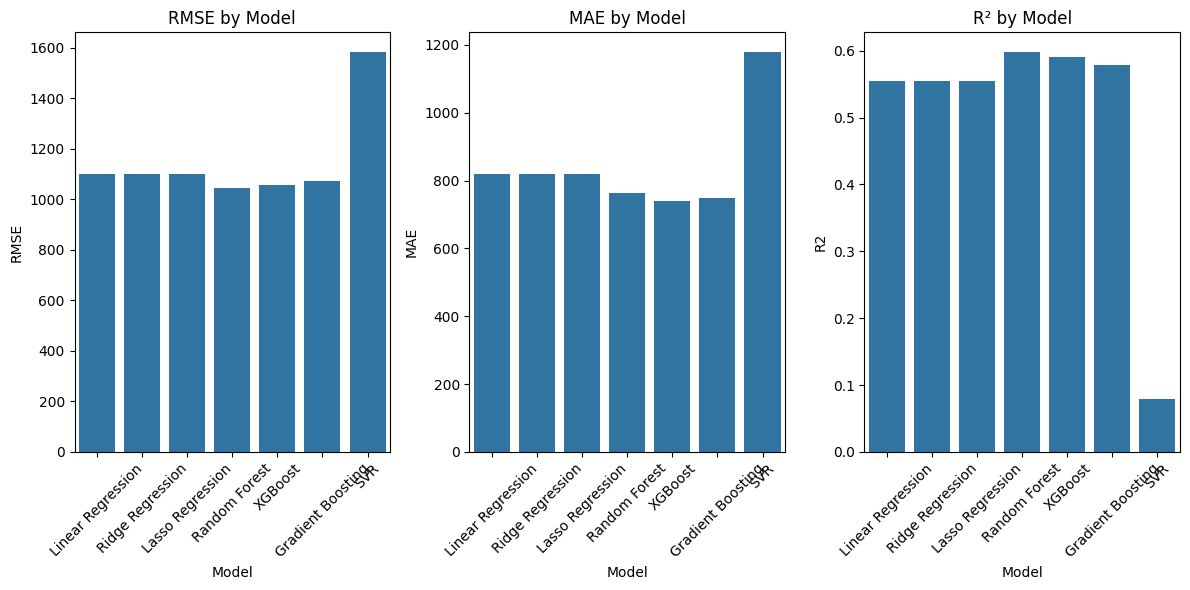

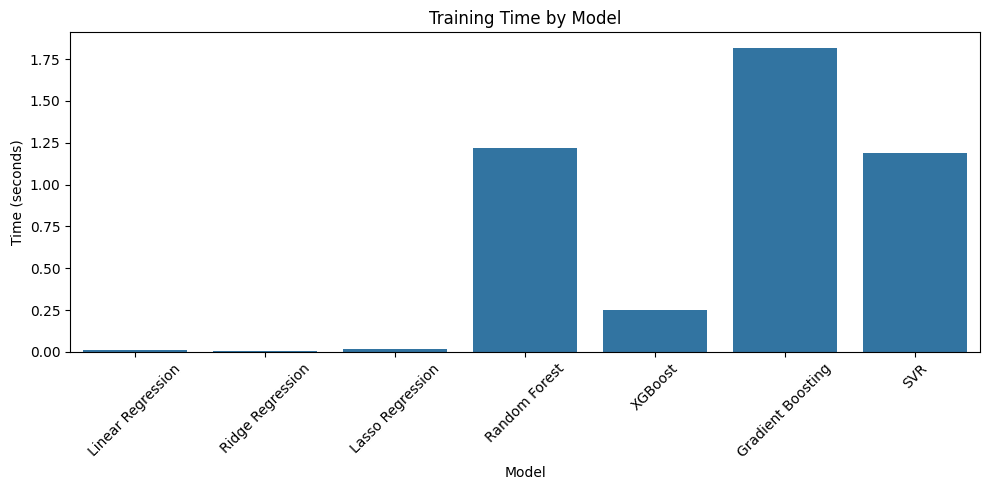


Лучшая модель по RMSE: Random Forest

Результаты сохранены в файл Bigmart_Random_Forest_Results.csv


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
import warnings
import time

# Отключаем предупреждения для чистоты вывода
warnings.filterwarnings('ignore')

# Функция для анализа структуры и статистик датасета
def analyze_dataset(df, name="Dataset"):
    """
    Выводит основную информацию о датасете:
    - размерность (количество строк и столбцов)
    - статистические характеристики числовых признаков
    - типы данных всех признаков
    """
    print(f"\n{name} Analysis:")
    print(f"Shape: {df.shape}")
    print("\nFeature Statistics:")
    print(df.describe())
    print("\nFeature Types:")
    print(df.dtypes)

# Функция для визуализации корреляций между признаками
def plot_correlations(df, target_col):
    """
    Создает тепловую карту корреляций и выводит корреляции с целевой переменной
    """
    plt.figure(figsize=(12, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelations with target variable:")
    correlations = df[numeric_cols].corr()[target_col].sort_values(ascending=False)
    print(correlations)

# Функция для очистки и предобработки данных
def clean_data(df):
    """
    Выполняет предобработку данных:
    1. Унификация категорий в Item_Fat_Content
    2. Создание новых признаков
    3. Обработка пропущенных значений
    """
    df = df.copy()
    # Унификация значений для содержания жира
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
        'low fat': 'Low Fat',
        'LF': 'Low Fat', 
        'reg': 'Regular'
    })
    
    # Создание новых информативных признаков
    df['num_years'] = 2013 - df['Outlet_Establishment_Year']
    df['Item_MRP_Scaled'] = np.log1p(df['Item_MRP'])
    df['Item_Visibility_Scaled'] = np.log1p(df['Item_Visibility'])
    
    # Заполнение пропущенных значений
    df['Item_Weight'] = df.groupby('Item_Type')['Item_Weight'].transform(
        lambda x: x.fillna(x.mean()))
    df['Outlet_Size'].fillna('Medium', inplace=True)
    
    return df

# Функция для оценки модели
def evaluate_model(y_true, y_pred, model_name):
    """
    Рассчитывает и возвращает основные метрики качества модели
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nМетрики для модели {model_name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    return rmse, mae, r2

# Функция для создания и обучения различных моделей
def create_models():
    """
    Создает словарь с различными моделями регрессии
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=4, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, subsample=0.8, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
        'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
    }
    return models

def plot_model_comparison(results_df):
    """
    Визуализирует сравнение метрик различных моделей
    """
    plt.figure(figsize=(12, 6))
    
    # График для RMSE
    plt.subplot(1, 3, 1)
    sns.barplot(x='Model', y='RMSE', data=results_df)
    plt.xticks(rotation=45)
    plt.title('RMSE by Model')
    
    # График для MAE
    plt.subplot(1, 3, 2)
    sns.barplot(x='Model', y='MAE', data=results_df)
    plt.xticks(rotation=45)
    plt.title('MAE by Model')
    
    # График для R²
    plt.subplot(1, 3, 3)
    sns.barplot(x='Model', y='R2', data=results_df)
    plt.xticks(rotation=45)
    plt.title('R² by Model')
    
    plt.tight_layout()
    plt.show()

def plot_training_times(results_df):
    """
    Визуализирует время обучения различных моделей
    """
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='Training Time', data=results_df)
    plt.xticks(rotation=45)
    plt.title('Training Time by Model')
    plt.ylabel('Time (seconds)')
    plt.tight_layout()
    plt.show()

def main():
    # Загрузка данных
    print("Загрузка данных...")
    train_data = pd.read_csv('Train.csv')
    test_data = pd.read_csv('Test.csv')
    
    # Анализ данных
    analyze_dataset(train_data, "Training Data")
    
    # Предобработка данных
    print("\nПредобработка данных...")
    train_data = clean_data(train_data)
    test_data = clean_data(test_data)
    
    # Подготовка признаков
    categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 
                       'Outlet_Location_Type', 'Outlet_Type']
    
    # Кодирование категориальных признаков
    train_data_encoded = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
    test_data_encoded = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)
    
    # Формирование признаков
    feat_cols = ['Item_Weight', 'Item_Visibility_Scaled', 'Item_MRP_Scaled', 
                'num_years'] + [col for col in train_data_encoded.columns 
                if col.startswith(tuple(categorical_cols))]
    
    # Подготовка данных
    X = train_data_encoded[feat_cols]
    y = train_data_encoded['Item_Outlet_Sales']
    X_test_actual = test_data_encoded[feat_cols]
    
    # Масштабирование признаков
    scaler = StandardScaler()
    numeric_cols = ['Item_Weight', 'Item_Visibility_Scaled', 'Item_MRP_Scaled', 'num_years']
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    X_test_actual[numeric_cols] = scaler.transform(X_test_actual[numeric_cols])
    
    # Разделение данных
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Создание моделей
    models = create_models()
    
    # Списки для хранения результатов
    results = []
    
    # Обучение и оценка моделей
    print("\nОбучение и оценка моделей...")
    for name, model in models.items():
        print(f"\nОбучение модели: {name}")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        y_pred = model.predict(X_val)
        rmse, mae, r2 = evaluate_model(y_val, y_pred, name)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Training Time': training_time
        })
    
    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    # Вывод сводной таблицы результатов
    print("\nСводная таблица результатов:")
    print(results_df.to_string(index=False))
    
    # Визуализация результатов
    print("\nВизуализация сравнения моделей...")
    plot_model_comparison(results_df)
    plot_training_times(results_df)
    
    # Выбор лучшей модели по RMSE
    best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
    best_model = models[best_model_name]
    
    print(f"\nЛучшая модель по RMSE: {best_model_name}")
    
    # Получение предсказаний лучшей модели для тестового набора
    y_result = best_model.predict(X_test_actual)
    
    # Формирование и сохранение результатов
    result = pd.DataFrame({
        'Item_Identifier': test_data['Item_Identifier'],
        'Outlet_Identifier': test_data['Outlet_Identifier'],
        'Item_Outlet_Sales': y_result
    })
    
    output_filename = f'Bigmart_{best_model_name.replace(" ", "_")}_Results.csv'
    result.to_csv(output_filename, index=False)
    print(f"\nРезультаты сохранены в файл {output_filename}")

if __name__ == "__main__":
    main()